[View in Colaboratory](https://colab.research.google.com/github/rutgerhofste/bq-geoms/blob/master/Y2018M08D24_RH_Hexagonal_Grid_V01.ipynb)

Python 3 runtime

#  Create global hexagonal grid. 

Use case: Hexbin in Google Bigquery.

Question on [stack exchange](https://gis.stackexchange.com/questions/293780/create-hexbin-honeycomb-grid-using-command-line-or-python/293811#293811)









There are multiple ways to create a tesselation based on hexagons. 

## pointy hexagons

![pointy hexagons](https://image.ibb.co/gioAa9/pointy.png)

## flat hexagons

![flat hexagons](https://preview.ibb.co/mT6Dv9/flat.png)

## Tesselation

![grids](https://preview.ibb.co/j6ubXp/Capture.png)

lets start with odd-r for pointy polygons. (left) Further note that in this script the lower left corner is 0,0.

The result is a geopandas geodataframe. In order to ingest the data into BigQuery, you need to setup credentials. This script includes a handy functionality where you can point to credentials in you google drive. Alternatively you can also copy-paste but this is less secure. More info [here](https://pandas-gbq.readthedocs.io/en/latest/howto/authentication.html)

Please add comments or improve this script. 

TODO:
1. Allow other orientations, tesselations and coordinate systems. 
1. Add parallel processing.

In [0]:
 !pip install shapely geopandas descartes sqlalchemy pydrive psycopg2

In [0]:
import math
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.wkt import dumps, loads

from google.cloud import bigquery
from google.colab import auth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials


In [0]:
def generate_angles(orientation="flat"):
  """ Generate angles in radians.
  
  Args:
    orientation (string): determine orientation. 'flat' or 'pointy' defaults to
      'flat'.
  Returns:
    angles (list): list of angles in radians.
   
  """
  
  angles = []  
  if orientation == 'flat':
      for i in range(0,6):
          angles.append((1/3)*math.pi*i)
  
  elif orientation == 'pointy':   
      for i in range(0,6):
          angles.append((1/3)*math.pi*i + 1/6*math.pi)
  else:
      raise Exception("orientation should be 'flat' or 'pointy'")
  return angles


def hex_corners(center_x,center_y, r, angles):
    """ Create hexagonal polygon. 
    
    Args:
      center_x (float): X coordinate of center.
      center_y (float): Y coordinate of center.
      r (float): Radius of hexagon (distance center-corner)
      angles (list): Angles in radians. 
    Returns:
      polygon (shapely polygon) : 
    
    """ 
    coords = []
    for angle in angles:
        x = center_x + r * math.cos(angle)
        y = center_y + r * math.sin(angle)
        coords.append((x,y))
    
    polygon = Polygon(coords)
    return polygon
  
  
def create_extent_polygon(x_min,x_max,y_min,y_max):
    llcrn = (x_min,y_min)
    ulcrn = (x_min,y_max)
    urcrn = (x_max,y_max)
    lrcrn = (x_max,y_min)  
    extent = Polygon((llcrn,ulcrn,urcrn,lrcrn))
    return extent
  
def create_grid(r=1,orientation="pointy",offset_coordinates="odd_r",clipping=True,x_min=-180,x_max=180,y_min=-90,y_max=90):
    """ Create Hexogonal grid

    see this guide for orientattion and offset:
    https://www.redblobgames.com/grids/hexagons/

    The function is crs agnostic.

    TODO: 
    1. Currently only pointy-odd_r supported. 
    1. Allow parallel processing, make polygon creation separate function.

    Args: 
      r (float): radius in arc degrees. Defaults to 1
      orientation (string): Orientatation of hexagons of type : 'flat' or 'pointy'
        defaults to pointy.
      offset_coordinates (string): numbering of polygons of type: 'odd_r' or 
        'even_r' for pointy polygons and 'odd_q' and 'even_q' for flat polygons.
      clipping(boolean): clip to extent.
      x_min(float): minimum longitude. Default -180.
      x_max(float): maximum longitude. Default 180.
      y_min(float): minimum latitude. Default -90.
      y_max(float): maximum latitude. Default 90.

    Returns:
      gdf(geoDataFrame) geoDataFrame with polygons and metadata.


    """

    flat_topped_angles = generate_angles(orientation="flat")
    pointy_topped_angles = generate_angles(orientation="pointy")
    
    #The diameter measures from point to point
    dia_major = 2*r  
    
    #diameter from side to side, called dia_minor
    dia_minor = math.sqrt(3) * r     
    
    extent_polygon = create_extent_polygon(x_min,x_max,y_min,y_max)
    
    if orientation =="pointy" and offset_coordinates=="odd_r":
        y = y_min
        ys = []
        while y < y_max + (3/4)*dia_major :
            ys.append(y)
            y = y + (3/4)*dia_major

        centres = []
        for row_number,y in enumerate(ys):
            col_number = 0
            if row_number % 2 == 0:
                # even row, no horizontal shift
                x = x_min
                while x < x_max+dia_minor:
                    polygon = hex_corners(x,y,r, pointy_topped_angles)
                    
                    if clipping:
                        polygon = polygon.intersection(extent_polygon)
                    
                    feature = {"row_number":row_number,"col_number":col_number,"x":x,"y":y,"polygon":polygon}
                    centres.append(feature)
                    x = x + dia_minor
                    col_number += 1
            else:
                # odd row, shift right with 1/2 dia_minor
                x = x_min + (1/2)*dia_minor
                while x < x_max+dia_minor:
                    polygon = hex_corners(x,y,r, pointy_topped_angles)
                    
                    if clipping:
                        polygon = polygon.intersection(extent_polygon)
                    
                    
                    feature = {"row_number":row_number,"col_number":col_number,"x":x,"y":y,"polygon":polygon}
                    centres.append(feature)
                    x = x + dia_minor
                    col_number += 1
        gdf = gpd.GeoDataFrame(centres,geometry="polygon")
    else:
      raise Exception("currently only supports 'pointy and 'odd_r'")
    return gdf
  
  
def r_finder_minor(n,dist_min,dist_max):
    """ find radius based on distance and number of polygons stacked on minor 
    axis (horizontal if point, vertical if flat)    
        
      Args:
        n (integer) : number of hexagons to fit stacked over minor axis.
        dist_min (float) : minimum distance. 
        dist_max (float) : maximum distance. 
      Returns:
        r (float): radius of hexagon (center-corner).
            
    """
    distance = dist_max - dist_min    
    dia_minor = distance / float(n)
    r = dia_minor/math.sqrt(3)    
    return r
    

  
  

In [0]:
# Settings

orientation = 'pointy'
offset_coordinates="odd_r"
clipping = True


# Avoid polar regions. (ver long polygons due to projection)
x_min=-180
x_max= 180
y_min=-80
y_max= 80

# Number of hexagons in x direction, pointy-even_r. 
# Script is not optimized yet so use n<1000 (1000 takes appr. 1 min)

n = 36 
r = r_finder_minor(n,x_min,x_max)



# simply use dia_major = 2r for other direction or if you are using flat polygons. 

In [0]:
gdf = create_grid(r=r,
                  orientation=orientation,
                  offset_coordinates=offset_coordinates,
                  clipping = clipping,
                  x_min=x_min,
                  x_max=x_max,
                  y_min=y_min,
                  y_max=y_max)

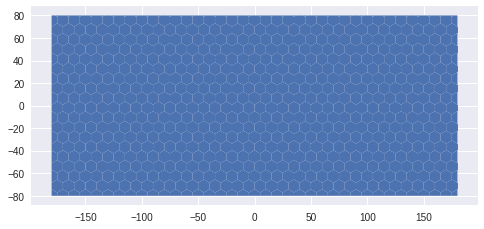

In [0]:
gdf.plot()

# GPD to BQ 

At this point we have a fully functional hexgrid in GeoDataFrame format.   
Next we will convert the geodataframe to WKT or GeoJSON and ingest in BigQuery. 

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Google Drive ID of the google bigquery creds.
# change to your own credentials.

BQ_CREDS_ID = "1JzjuosHbtV7mzE0f85ZTXsNc2X4p8BFK"
BQ_PROJECT_ID = "aqueduct30"

OUTPUT_DATASET = "spatial_test" #create dataset first if not exist.
OUTPUT_TABLE_NAME = "hexagons_wkt"

bq_file = drive.CreateFile({'id': BQ_CREDS_ID}).GetContentString()
client = bigquery.Client(project=BQ_PROJECT_ID)

In [0]:
gdf["polygon_wkt"] = gdf["polygon"].apply(lambda x: dumps(x))

In [0]:
df = gdf.drop("polygon",axis=1)

In [0]:
df.head()

,col_number,row_number,x,y,polygon_wkt
0,0,0,-180.0,-80.0,POLYGON ((-180.0000000000000000 -74.2264973081...
1,1,0,-170.0,-80.0,POLYGON ((-175.0000000000000000 -80.0000000000...
2,2,0,-160.0,-80.0,POLYGON ((-165.0000000000000000 -80.0000000000...
3,3,0,-150.0,-80.0,POLYGON ((-155.0000000000000000 -80.0000000000...
4,4,0,-140.0,-80.0,POLYGON ((-145.0000000000000000 -80.0000000000...


In [0]:
destination_table = "{}.{}".format(DATASET,OUTPUT_TABLE_NAME)

In [0]:
df.to_gbq(destination_table=destination_table,
          project_id = BQ_PROJECT_ID,
          if_exists="replace")

Now the data is in WKT on bigquery. You can visualize using:
https://bigquerygeoviz.appspot.com/

the last step would be to convert the WKT to geometry on bigquery. 
SELECT *, ST_GeogFromText(polygon_wkt) AS g FROM `aqueduct30.spatial_test.hexagons_wkt`

please note that that the hexagons will be in Geopraphy instead of geometry!

happy hexbinning!

